## Basic Librosa

In [1]:
# importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import librosa
import librosa.display
import IPython

import os

In [2]:
file = '/Users/jmd/Documents/BOOTCAMP/Capstone/the-circor-digiscope-phonocardiogram-dataset-1.0.1/training_data/2530_AV.wav'

In [3]:
# lets take a listen
IPython.display.Audio(file)

In [4]:
signal, sr = librosa.load(file) # signal is the array that contains the amplitude of the waveform at a given point in time.
                            # sr is the sampling rate, defaults to 22050 hz.
print(len(signal))          # we've got 520380 data points for this one .wav file...
print(len(signal)/sr)       # .wav file is 23.6 seconds long. 

520380
23.6


In [5]:
sr

22050

In [6]:
signal.shape

(520380,)

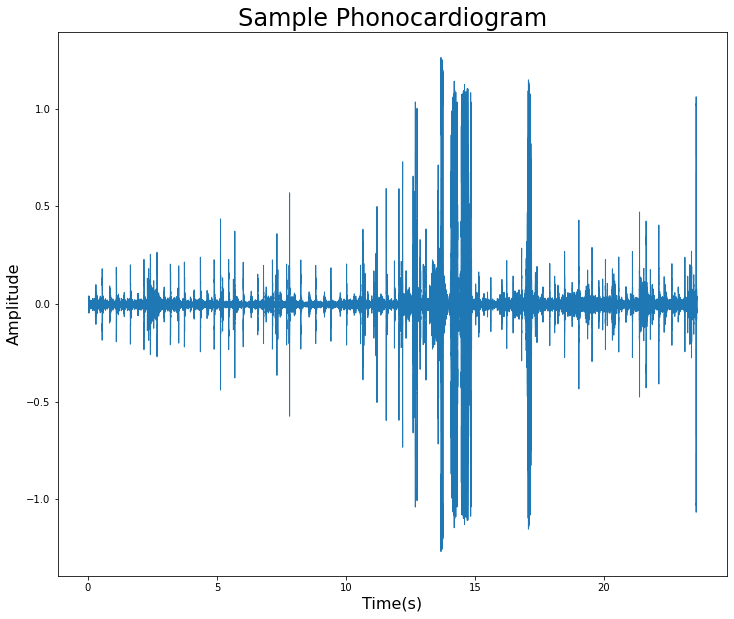

In [7]:
# visualizing the waveform from the imported .wav file.
plt.figure(figsize=(12,10))
librosa.display.waveshow(signal, sr = sr)
plt.ylabel("Amplitude", size=16)
plt.xlabel('Time(s)', size=16)
plt.title('Sample Phonocardiogram', size=24)
plt.savefig(fname='/Users/jmd/Documents/BOOTCAMP/Capstone/sample_phonocardiogram.png')

In [8]:
# fast fourier transform, goal of converting it to a spectrum
fft = np.fft.fft(signal) # returns an array of complex numbers
fft

array([-132.58879333 +0.j        ,   48.17535493 +4.90108609j,
         -6.70912643-38.53483667j, ...,  -98.36048657-12.62779976j,
         -6.70912643+38.53483667j,   48.17535493 -4.90108609j])

In [9]:
# now pulling out the magnitude of these values
magnitude = np.abs(fft) # abs of a complex value
frequency = np.linspace(0,sr, len(magnitude)) # interval we input is between a frequency of 0 hz and our sample rate, performing this over the length of the magnitude array. 

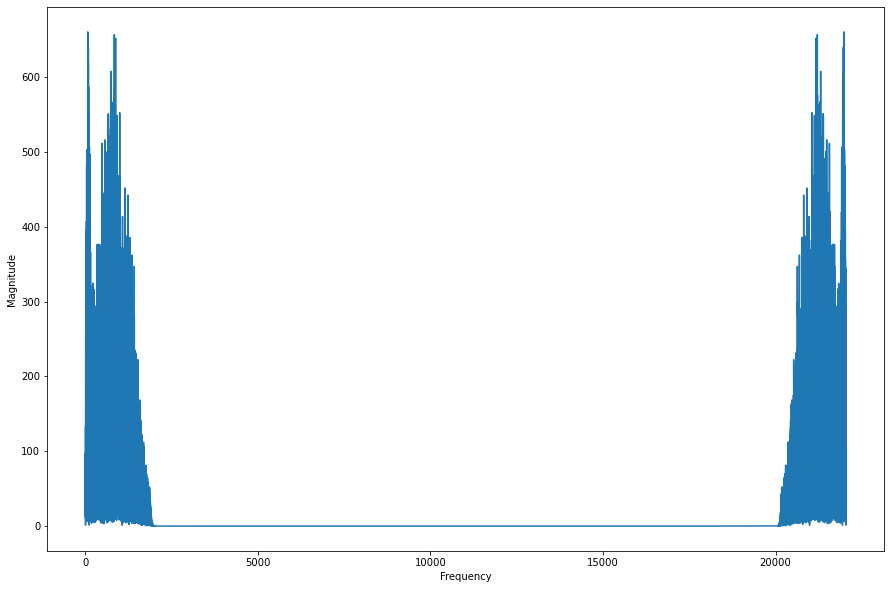

In [10]:
# lets plot our frequencies.
plt.figure(figsize=(15,10))
plt.plot(frequency, magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()
# plot is symmetric about the SR. Thus we only need half the plot. 

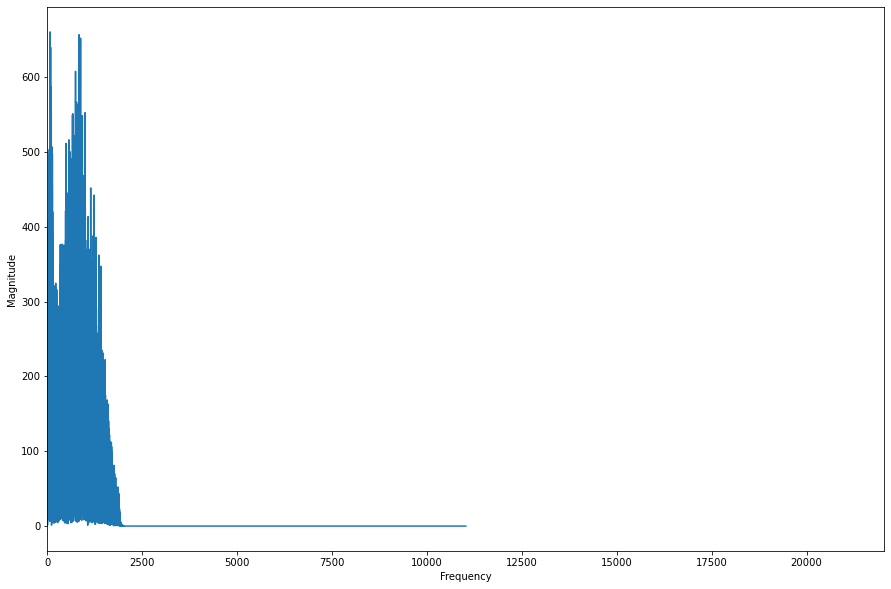

In [11]:
#thus
left_frequency = frequency[:int(len(frequency)/2)]
left_magnitude = magnitude[:int(len(magnitude)/2)]

# re-plotting our frequencies.
plt.figure(figsize=(15,10))
plt.plot(left_frequency, left_magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.xlim(0,sr)
plt.show()

In [12]:
# this is static - a snapshot average of the whole sound throughout time. 
# to remedy this, we need to perform a short time fourier transform to produce a spectrogram. This will give us information about the amplitude as a function of both frequency and time. 

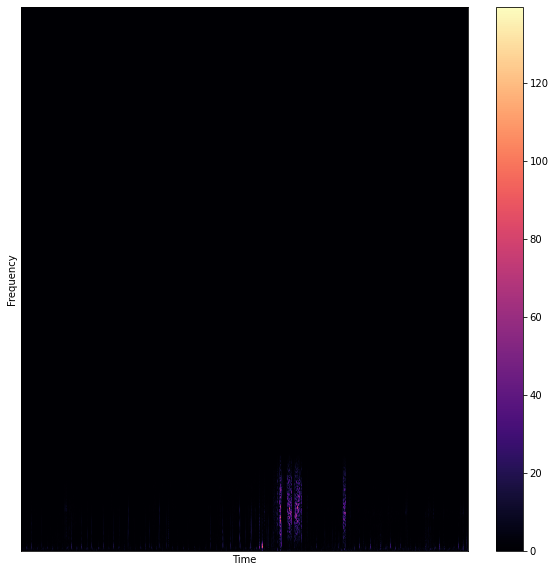

In [26]:
n_fft = 1024 # number of samples per fft. "the window" we are considering when performing a single fast fourier transform. 
hop_length = 256 # the amount we are shifting each fourier transform to the right. 

stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)

# now from these values, we move to the spectrogram.

spectrogram = np.abs(stft)

plt.figure(figsize=(10,10))
librosa.display.specshow(spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

Fig 1. What this shows us is that MOST frequencies have very little contribution to the overall sound throughout time. The contribution of frequencies is heavily concentrated to the lower ranges. 

In [14]:
# lets calculate the log spectrogram

log_spectrogram = librosa.amplitude_to_db(spectrogram)

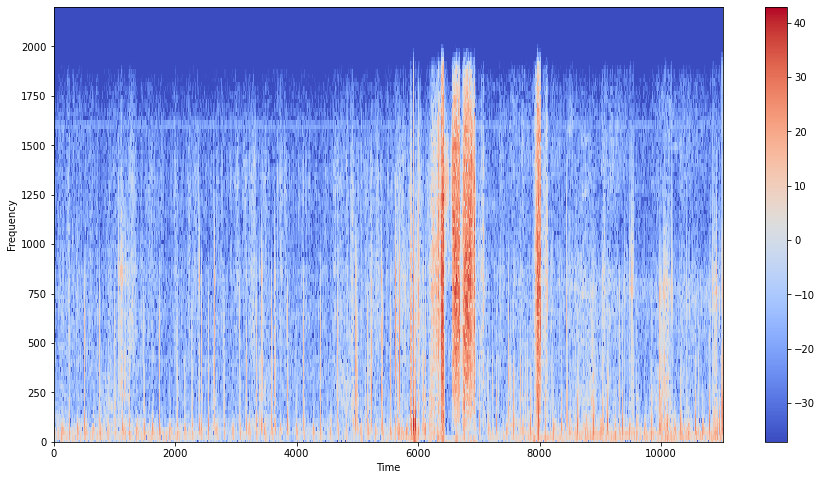

In [15]:
plt.figure(figsize=(15,8))
librosa.display.specshow(log_spectrogram, y_axis='hz', x_axis='linear')
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.ylim(0,2200)
plt.colorbar()
plt.savefig(fname='/Users/jmd/Documents/BOOTCAMP/Capstone/sample_spectrogram.png')

In [24]:
# lastly, we can extract the MFCCs

MFCCs = librosa.feature.mfcc(signal, n_fft=n_fft, hop_length=hop_length, n_mfcc=20)

/var/folders/zf/j9yckf9x41gbrplj0b23dt700000gn/T/ipykernel_38911/2455047630.py:3: FutureWarning: Pass y=[-0.01187718 -0.0068538   0.0005533  ...  0.00115476  0.00057282
  0.00019825] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  MFCCs = librosa.feature.mfcc(signal, n_fft=n_fft, hop_length=hop_length, n_mfcc=20)


In [25]:
MFCCs.shape

(20, 2033)

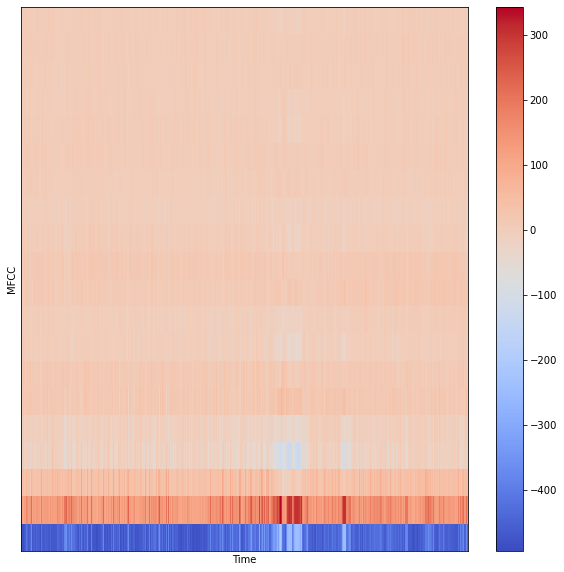

In [17]:
plt.figure(figsize=(10,10))
librosa.display.specshow(MFCCs, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.savefig(fname='/Users/jmd/Documents/BOOTCAMP/Capstone/sample_MFCC.png')

Questions for Arad:

- Seems that I have two options: 
    * Traditional ML Pipeline for audio data which includes feature engineering and deriving features from sound data. 
    * Deep Learning which apparently relies on inputting the spectrograms generated with librosa into a deep learning model. </br>
    
I'm leaning more towards the former for the following reasons:
* Working with medical information - explainability is important
* I will have more granular ctrl over the "guts" of the algorith I'm building

Drawbacks:
* It's gonna be freakin hard

Additional Considerations:
* MFCCs? Unsure if I should use them. 
* How deeply should I understand the math behind fourier transforms for presenting/talking about this topic b/c currently I understand next to nothing.
* Filtering out noise - how to approach this problem? Is it just regularization?
* find a way to feed in patient demographic information into the 